# Aplicando Redes Neurais Artificiais em Séries Temporais para prever volume de vendas de uma fábrica de picolés.

## Introdução

Vamos começar importando o Pandas e as bases de dados que serão usadas para esta análise.

**OBSERVAÇÃO IMPORTANTE.** Caso dê erro ao carregar as bases de dados, siga os seguintes passos:


1.   Faça Login em sua conta do Google Drive;
2.   Navegue até a pasta "Compartilhados Comigo";
3.   Clique com o botão direito sobre a pasta "UffData";
4.   Selecione a opção "Adicionar a Meu Drive";
5.   Rode novamente este notebook;



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

alasca_path = "/content/drive/My Drive/UffData/Alasca_nordeste.csv"
macroeconomia_path = "/content/drive/My Drive/UffData/macroeconomia.csv"

alasca = pd.read_csv(alasca_path, sep=';')
economia = pd.read_csv(macroeconomia_path, sep=';')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
alasca.head()

,Data,Total,SM,ROUTE,INDIRETOS,Week_445,Month_445,Day_gregoriano,Month_gregoriano,Year,Data.1,holidays,weekend,work_day
0,(01/jan) S 01/01/15,"1.140.939,79","53.836,01","445.628,58","279.716,45",1,1,1,1,2015,01/01/2015,1,0,0
1,(10/jan) S 02/01/15,"1.208.345,05","44.632,77","411.396,38","373.728,09",2,1,10,1,2015,10/01/2015,0,3,6
2,(17/jan) S 03/01/15,"1.232.568,27","50.346,89","377.523,01","414.361,51",3,1,17,1,2015,17/01/2015,0,2,5
3,(24/jan) S 04/01/15,"1.286.220,81","59.593,78","404.243,53","409.215,53",4,1,24,1,2015,24/01/2015,0,2,5
4,(31/jan) S 01/02/15,"932.421,50","40.541,61","335.083,88","260.696,61",1,2,31,1,2015,31/01/2015,0,2,5


In [3]:
economia.head()

,Data,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
0,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
1,01/02/2015,"27,66","24.420,64","259,70","85,23","5.047.993,34","1.588,12","9,28"
2,01/03/2015,"27,31","24.420,64","263,13","93,35","5.047.993,34","1.588,12","9,28"
3,01/04/2015,"27,29","24.386,35","264,99","89,54","4.998.964,77","1.574,55","9,94"
4,01/05/2015,"26,68","24.386,35","266,96","93,91","4.998.964,77","1.574,55","9,94"


Para juntar ambos os datasets, iremos usar as colunas que representam o mês e o ano das vendas.

In [4]:
economia.Data.dtypes

dtype('O')

Os dados da coluna 'Data' na tabela 'economia' estão no formato string. Portanto, iremos passar esses dados para o tipo datetime e então extrair o mês e o ano.

In [0]:
# Convertendo a Coluna 'Data' da tabela 'economia' e extraindo o mês e o ano

economia['Month_gregoriano'] = economia.Data.map(lambda date : pd.to_datetime(date, format='%d/%m/%Y').month)
economia['Year'] = economia.Data.map(lambda date : pd.to_datetime(date, format='%d/%m/%Y').year)

In [6]:
# Juntando os datasets

df = alasca.merge(economia, how='left', on=['Year', 'Month_gregoriano'])
df.head()

,Data_x,Total,SM,ROUTE,INDIRETOS,Week_445,Month_445,Day_gregoriano,Month_gregoriano,Year,Data.1,holidays,weekend,work_day,Data_y,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
0,(01/jan) S 01/01/15,"1.140.939,79","53.836,01","445.628,58","279.716,45",1,1,1,1,2015,01/01/2015,1,0,0,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
1,(10/jan) S 02/01/15,"1.208.345,05","44.632,77","411.396,38","373.728,09",2,1,10,1,2015,10/01/2015,0,3,6,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
2,(17/jan) S 03/01/15,"1.232.568,27","50.346,89","377.523,01","414.361,51",3,1,17,1,2015,17/01/2015,0,2,5,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
3,(24/jan) S 04/01/15,"1.286.220,81","59.593,78","404.243,53","409.215,53",4,1,24,1,2015,24/01/2015,0,2,5,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
4,(31/jan) S 01/02/15,"932.421,50","40.541,61","335.083,88","260.696,61",1,2,31,1,2015,31/01/2015,0,2,5,01/01/2015,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"


In [7]:
df.shape

(242, 22)

## Limpeza e Transformação de variáveis

Agora que temos todos os dados em uma única tabela, vamos começar o trabalho de limpeza e transformação das variáveis.

In [8]:
df.drop(['Data_y', 'Data_x'], axis='columns', inplace=True)
df.rename(columns={'Data.1': 'Data'}, inplace=True)
df.Data = pd.to_datetime(df.Data, format="%d/%m/%Y")
df.set_index('Data', inplace=True)
df.head()

,Total,SM,ROUTE,INDIRETOS,Week_445,Month_445,Day_gregoriano,Month_gregoriano,Year,holidays,weekend,work_day,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
Data,,,,,,,,,,,,,,,,,,,
2015-01-01,"1.140.939,79","53.836,01","445.628,58","279.716,45",1,1,1,1,2015,1,0,0,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
2015-01-10,"1.208.345,05","44.632,77","411.396,38","373.728,09",2,1,10,1,2015,0,3,6,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
2015-01-17,"1.232.568,27","50.346,89","377.523,01","414.361,51",3,1,17,1,2015,0,2,5,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
2015-01-24,"1.286.220,81","59.593,78","404.243,53","409.215,53",4,1,24,1,2015,0,2,5,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"
2015-01-31,"932.421,50","40.541,61","335.083,88","260.696,61",1,2,31,1,2015,0,2,5,"27,54","24.420,64","256,57","97,99","5.047.993,34","1.588,12","9,28"


### Tratando valores Missing

Iniciaremos esta tarefa procurando valores em branco, ou seja, valores do tipo 'Nan'. 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242 entries, 2015-01-01 to 2019-08-17
Data columns (total 19 columns):
Total               242 non-null object
SM                  242 non-null object
ROUTE               242 non-null object
INDIRETOS           242 non-null object
Week_445            242 non-null int64
Month_445           242 non-null int64
Day_gregoriano      242 non-null int64
Month_gregoriano    242 non-null int64
Year                242 non-null int64
holidays            242 non-null int64
weekend             242 non-null int64
work_day            242 non-null int64
temperatura         242 non-null object
Ocupacao            242 non-null object
Ajuste_ipca         242 non-null object
PMC                 242 non-null object
Massa.Renda         242 non-null object
Renda               242 non-null object
Desemprego          242 non-null object
dtypes: int64(8), object(11)
memory usage: 37.8+ KB


Nenhuma coluna apresenta valores missing.

### Parsing

Vamos olhar para o tipo nos quais os dados estão sendo representados.

In [10]:
df.dtypes

Total               object
SM                  object
ROUTE               object
INDIRETOS           object
Week_445             int64
Month_445            int64
Day_gregoriano       int64
Month_gregoriano     int64
Year                 int64
holidays             int64
weekend              int64
work_day             int64
temperatura         object
Ocupacao            object
Ajuste_ipca         object
PMC                 object
Massa.Renda         object
Renda               object
Desemprego          object
dtype: object

Note que algumas variáveis são de natureza numérica e estão representadas em outro formato.
Vamos definir uma função para transformar essas variáveis para o tipo 'float' e então aplicaremos a transformação.

In [0]:
def str_to_int(col):
    '''Função que recebe uma coluna com dados do tipo string e os tranforma em float'''
    
    new_column = []
    
    for item in col:
        item = item.replace('.', '').replace(',', '.')
        new_column.append(float(item))
    
    return new_column

In [0]:
str_to_int_cols = ['Total', 'SM', 'ROUTE', 'INDIRETOS', 'temperatura', 'Ocupacao', 'Ajuste_ipca', 'PMC',
                   'Massa.Renda', 'Renda', 'Desemprego']

for column in str_to_int_cols:
    df[column] = str_to_int(df[column])

In [13]:
df.dtypes

Total               float64
SM                  float64
ROUTE               float64
INDIRETOS           float64
Week_445              int64
Month_445             int64
Day_gregoriano        int64
Month_gregoriano      int64
Year                  int64
holidays              int64
weekend               int64
work_day              int64
temperatura         float64
Ocupacao            float64
Ajuste_ipca         float64
PMC                 float64
Massa.Renda         float64
Renda               float64
Desemprego          float64
dtype: object

Antes de seguirmos com a análise, vamos guardar uma cópia dos dados para que seja feita uma comparação de performance entre os modelos treinados com dados brutos e dados transformados.

In [0]:
df_copy = df

## Análise Exploratória

Vamos explorar nossas variáveis e entender como elas se relacionam com o volume de vendas.

In [0]:
import matplotlib.pyplot as plt

In [16]:
df.head()

,Total,SM,ROUTE,INDIRETOS,Week_445,Month_445,Day_gregoriano,Month_gregoriano,Year,holidays,weekend,work_day,temperatura,Ocupacao,Ajuste_ipca,PMC,Massa.Renda,Renda,Desemprego
Data,,,,,,,,,,,,,,,,,,,
2015-01-01,1140939.79,53836.01,445628.58,279716.45,1,1,1,1,2015,1,0,0,27.54,24420.64,256.57,97.99,5047993.34,1588.12,9.28
2015-01-10,1208345.05,44632.77,411396.38,373728.09,2,1,10,1,2015,0,3,6,27.54,24420.64,256.57,97.99,5047993.34,1588.12,9.28
2015-01-17,1232568.27,50346.89,377523.01,414361.51,3,1,17,1,2015,0,2,5,27.54,24420.64,256.57,97.99,5047993.34,1588.12,9.28
2015-01-24,1286220.81,59593.78,404243.53,409215.53,4,1,24,1,2015,0,2,5,27.54,24420.64,256.57,97.99,5047993.34,1588.12,9.28
2015-01-31,932421.50,40541.61,335083.88,260696.61,1,2,31,1,2015,0,2,5,27.54,24420.64,256.57,97.99,5047993.34,1588.12,9.28


Vamos analisar o comportamento do volume de vendas ao longo do tempo.

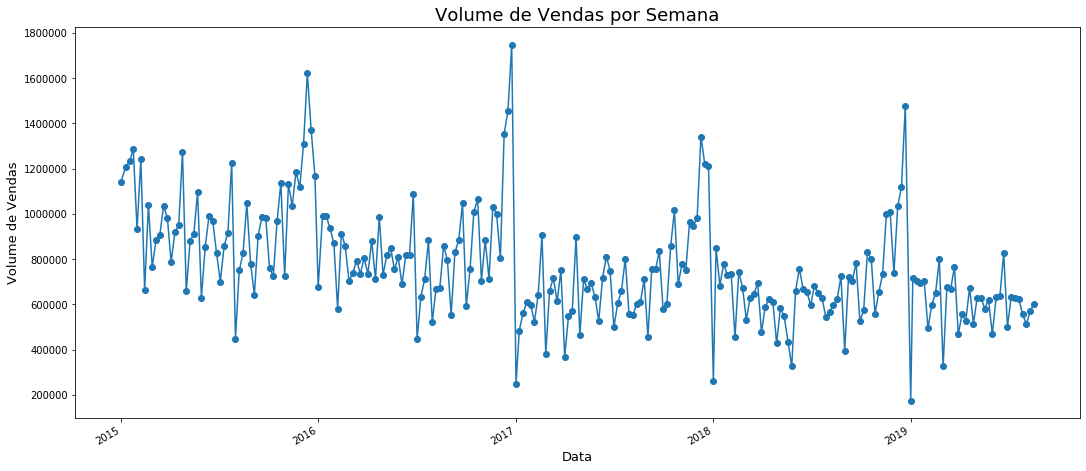

In [17]:
plt.figure(figsize=(18,8))

plt.plot_date(df.index , df.Total, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.xlabel('Data', fontsize=13)
plt.ylabel('Volume de Vendas', fontsize=13)
plt.title('Volume de Vendas por Semana', fontsize=18)
plt.show()

Como podemos observar, nos últimos meses de cada encontram-se os picos de vendas, enquanto nos primeiros meses é onde podemos notar uma queda drástica.
Vamos dar uma olhada mais de perto neste padrão.

Text(0, 0.5, 'Volume de Vendas')

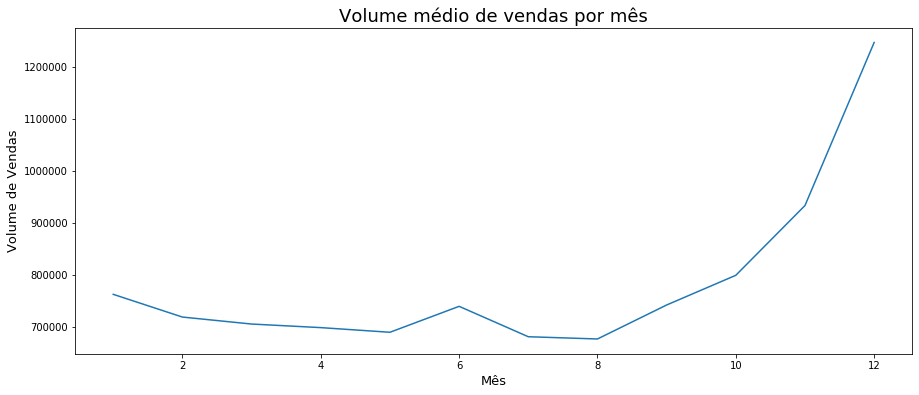

In [18]:
plt.figure(figsize=(15,6))

month = df.groupby(by='Month_gregoriano').mean().Total
plt.plot(month)
plt.title('Volume médio de vendas por mês', fontsize=18)
plt.xlabel('Mês', fontsize=13)
plt.ylabel('Volume de Vendas', fontsize=13)

Text(0, 0.5, 'Volume de Vendas')

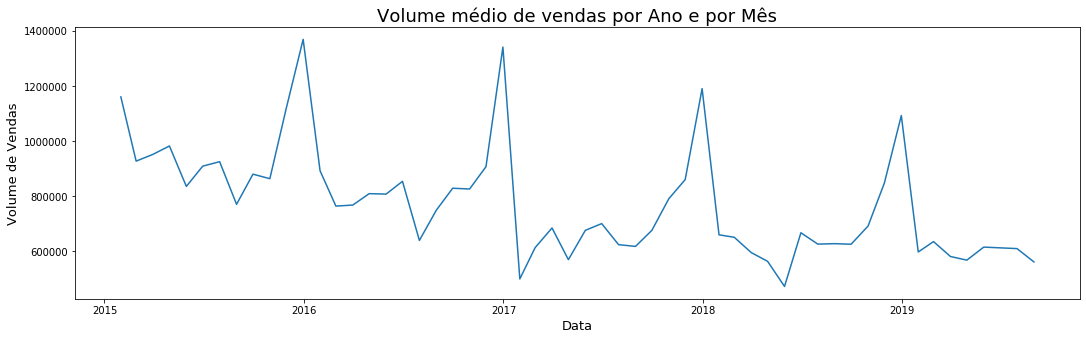

In [19]:
month_year = df.resample('M').mean().Total
plt.figure(figsize=(18,5))
plt.plot(month_year)
plt.title('Volume médio de vendas por Ano e por Mês', fontsize=18)
plt.xlabel('Data', fontsize=13)
plt.ylabel('Volume de Vendas', fontsize=13)

> Podemos fazer duas observações no gráfico acima:

1.   Existe uma tendência de queda no volume de vendas com o passar dos anos;
2.   Há sazonalidade nas vendas;

> Esses padrões indicam que as técnicas de anaálise de séries temporais podem obter bons resultados sobre esses dados.

> O objetivo de uma análise de séries temporais é analisar um determinado fato com base na série histórica de outras variáveis. Então, vamos comparar o comportamento no tempo de outras variáveis no nosso dataset com o volume de vendas.

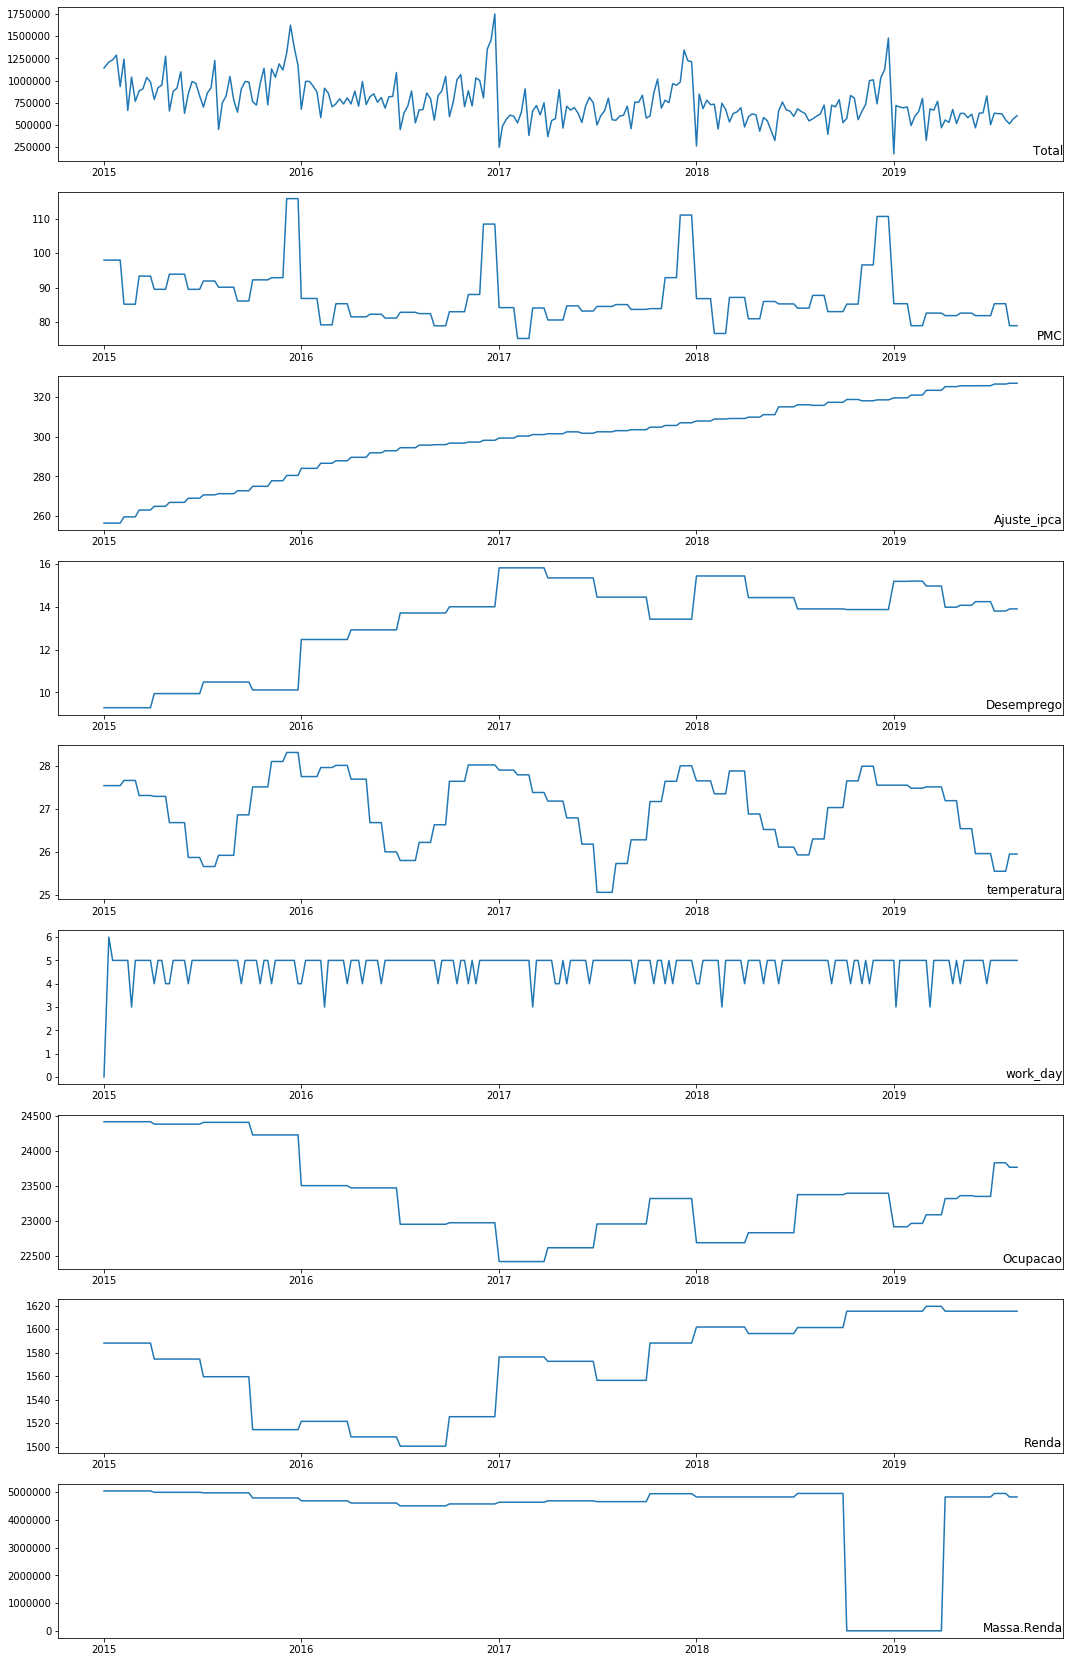

In [20]:
cols = ['Total', 'PMC', 'Ajuste_ipca', 'Desemprego', 'temperatura', 'work_day', 'Ocupacao', 'Renda', 'Massa.Renda']

plt.subplots(figsize=(18,30))

for i in range(len(cols)):
  plt.subplot(len(cols), 1, i+1)
  name_column = cols[i]
  plt.plot(df[name_column])
  plt.title(name_column, y=0, loc='right')
plt.show()



> Algumas observações a serem feitas em relação ao gráfico acima:

1.   Os picos da variável PMC ao fim de cada ano e a queda logo em sequência, assim como o volume de vendas;
2.   O aumento quase que linear do IPCA ao longo dos anos. Isso pode ajudar explicar a tendência de queda do volume de vendas;
3.   Todo início de ano o índice de desemprego acelera e ao longo do ano tende a estabilizar;

> Como essas foram as variáveis que melhor se relacionaram com o volume de vendas, iremos selecioná-las como variáveis preditores.







Como vimos anteriormente, o mês tem grande influência no volume de vendas. Além do mês, vamos enteder qual o comportamento das vendas por semana.

Text(0, 0.5, 'Volume de Vendas')

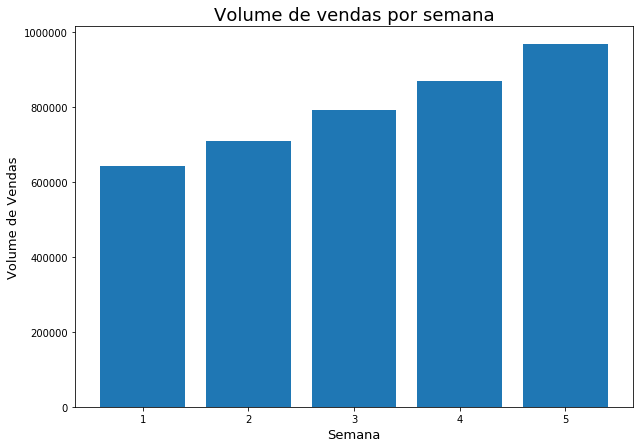

In [21]:
plt.figure(figsize=(10, 7))

y = df.groupby(by='Week_445').mean().Total
x = df['Week_445'].unique()

plt.bar(x, y)
plt.title('Volume de vendas por semana', fontsize=18)
plt.xlabel('Semana', fontsize=13)
plt.ylabel('Volume de Vendas', fontsize=13)

Em média, as vendas tendem a aumentar conforme as semanas transcorrem ao longo do mês. Sendo assim, além da variável mês, vamos usar as semanas como variáveis preditoras.

## Feature Engeneering

Além das variáveis já selecionadas, vamos analizar como que a variação (em termos absolutos) do volume de vendas da semana "anterior" podem afetar as vendas da semana "atual".

In [22]:
df['Diff-1W'] = df['Total'].diff(1).abs() #Calculando a diferença de uma semana para outra
df = df.iloc[1:, :] #Eliminando a primeira semana pois o valor na coluna 'Total-1W' do primeiro registro é 'null'
df.shape

(241, 20)

Comparando o volume de vendas com a variação entre as semanas.

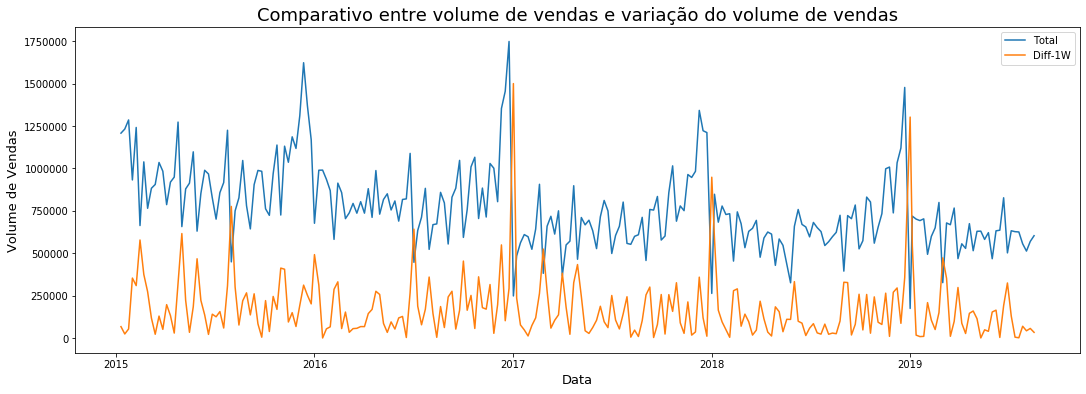

In [23]:
plt.figure(figsize=(18,6))

#plots
plt.plot(df.Total)
plt.plot(df['Diff-1W'])

#labels
plt.title('Comparativo entre volume de vendas e variação do volume de vendas', fontsize=18)
plt.xlabel('Data', fontsize=13)
plt.ylabel('Volume de Vendas', fontsize=13)
plt.legend(['Total', 'Diff-1W'])
plt.show()

Como podemos observar, as variações no volume de vendas ajudam a esplicar os pequeno picos e vales ao longo das semanas.

## Feature Selection

Vamos selecionar as variáveis do nosso dataset baseado nas análises feitas anteriormente.

In [0]:
df = df[['Total', 'PMC', 'Month_445', 'Week_445', 'Diff-1W', 'Ajuste_ipca', 'Desemprego']]

## Deep Learning

> A proposta de modelo escolhido para solucionar o problema foi a construção de um rede neural artificial recorrente (RNN). Esta escolha está diretamente ligada à natureza dos dados.

> As séries temporais tem por característica a dependência do passado nos acontecimentos do futuro. As RNNs são capazes de usar uma sequência de dados para prever uma determinada variável. Esta característica é a que nos interessa, uma vez que também iremos usar o próprio histórico do volume de vendas para prever o volume de vendas das próximas semanas.

### Pré-processamento dos dados

#### Dummy Variables

Em nosso dataset temos variáveis do tipo categóricas que estão representadas por números. Para evitar que modelo interprete essas variáveis como números e não como categorias, uma boa prática converter essas variáveis para 'dummy variabels'.

'Dummy variable' é uma maneira de representar as variáveis como sendo vetores binários.

In [25]:
categorical_columns = ['Month_445', 'Week_445']

for col in categorical_columns:
  dummies = pd.get_dummies(data=df[col], prefix=col, drop_first=True) #Drop na primeira coluna para evitar a 'dummy variable trap'
  df = pd.concat([df, dummies], axis='columns') #Juntando o dataframe resultante com o dataset original
df.drop(['Month_445', 'Week_445'], axis='columns', inplace=True) #Eliminando as colunas categóricas originais
df.head(1)

,Total,PMC,Diff-1W,Ajuste_ipca,Desemprego,Month_445_2,Month_445_3,Month_445_4,Month_445_5,Month_445_6,Month_445_7,Month_445_8,Month_445_9,Month_445_10,Month_445_11,Month_445_12,Week_445_2,Week_445_3,Week_445_4,Week_445_5
Data,,,,,,,,,,,,,,,,,,,,
2015-01-10,1208345.05,97.99,67405.26,256.57,9.28,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


#### Normalização dos Dados

> Outra boa prática é colocar todos os dados na mesma escala a fim de evitar que nosso modelo possa atribuir maior relevância para determinadas variáveis e menos para outras. Por exemplo, a diferença do volume de vendas é da ordem de grandeza de O(10^4) enquanto o índice de desemprego é da ordem de O(10).

> Para isso, vamos usar afunção MinMaxScaler do pacote sklearn.

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
scaled_df.head()

,Total,PMC,Diff-1W,Ajuste_ipca,Desemprego,Month_445_2,Month_445_3,Month_445_4,Month_445_5,Month_445_6,Month_445_7,Month_445_8,Month_445_9,Month_445_10,Month_445_11,Month_445_12,Week_445_2,Week_445_3,Week_445_4,Week_445_5
Data,,,,,,,,,,,,,,,,,,,,
2015-01-10,0.656600,0.560415,0.044535,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-17,0.671988,0.560415,0.015746,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-01-24,0.706070,0.560415,0.035366,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-01-31,0.481319,0.560415,0.235472,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-07,0.677867,0.245120,0.205872,0.044606,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Histórico

Agora vamos gerar o histórico das últimas 4 semanas para cada ponto de dados em nosso dataset. Ou seja, o volume de vendas de cada semana será predito pelo histórico do último mês de cada variável preditora no nosso conjunto de dados.

In [27]:
from numpy import array

def gera_historico(dados, n_semanas):
  X,y = list(), list()
  for i in range(len(dados)):
    #Encontra a ultima semana
    end_ix = i + n_semanas

    #Verifica se o indice é válido
    if end_ix > len(dados)-1:
      break
    
    # Obtem x e y
    seq_x = array(dados.iloc[i:end_ix])
    seq_y = dados.iloc[end_ix, 0]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

n_semanas = 4
X,y = gera_historico(scaled_df, n_semanas)

# Exemplificando os dados de treino:
# Cada item da lista representa os dados de uma semana.
# Como queremos o histórico das últimas 4 semanas, cada input será uma lista de 4 listas.
X[0]

array([[0.65659968, 0.56041512, 0.04453531, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.67198753, 0.56041512, 0.01574617, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.70607041, 0.56041512, 0.03536648, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.48131871, 0.56041512, 0.23547206, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

#### Divisão em dados de treino e dados de teste

>Agora vamos dividir os dados entre dados de treino e dados de teste. A divisão será de 9 pra 1 pois o nosso dataset é relativamente pequeno.

>Vale ressaltar que a divisão dos dados não será feita de forma aleatória pois,  em análises de séries temporais, a ordem dos acontecimentos é importante.

In [0]:
split_point = round(len(X) * 0.90)
x_train = X[:split_point]
x_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

Precisamos colocar nossos dados de treino no padrão que a camada de uma Rede Neural Artificial impõe. Ou seja, de [dados, n_meses] para [dados, n_meses, n_variaveis].

In [0]:
n_features = scaled_df.shape[1]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))

### Criando a Rede Neural Artificial Recorrente

>Como visto anteriormente, queremos usar os padrões encontrados nas séries temporais. Esses padrões se repetem a cada ano. Logo, nossa RNN não pode sofrer de ["vanishing gradient"](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). Então, vamos contruir camadas de neurônios do tipo Long short-term memory ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)).

>As primeiras camadas são do tipo [Bidirecional](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks). Camadas desse tipo recebem informações tanto de camadas anteriores, como de camadas posteriores. Assim, a RNN é capaz de adquirir melhores informações sobre o contexto da sequência de dados.

In [30]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
 
activation_func = 'softplus'
dropout = 0.0

model = Sequential()
model.add(Bidirectional(LSTM(n_features*n_semanas,
                             activation=activation_func,
														 return_sequences=True,
														 input_shape=(n_semanas, n_features),
														 dropout=dropout
														 )))
model.add(Bidirectional(LSTM(n_features*n_semanas, activation=activation_func, return_sequences=True, dropout=dropout)))
model.add(LSTM(n_features*n_semanas, activation=activation_func, dropout=dropout))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae', metrics=['mae'])

Using TensorFlow backend.


### Treinando o Modelo

In [31]:
history = model.fit(x_train, y_train, epochs=300, validation_split=0.1, batch_size=32, verbose=0, shuffle=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










### Validação do Modelo

A primeira verificação a se fazer é comparar os erros dos dados de treino com os dados de validação  ao longo das iterações.

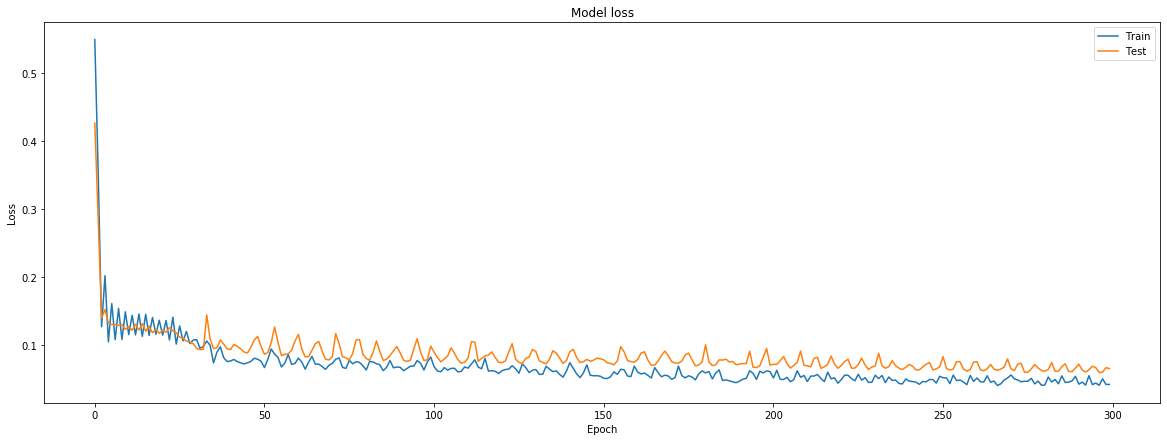

In [32]:
plt.figure(figsize=(20,7))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

A direfença entre o erro nos dado de treino e dados de testes é bem sutíl. Logo, o nosso modelo não sofre de Overfitting.

Em seguida, vamos usar o modelo para realizar algumas predições sobre os dados de teste.

In [0]:
y_pred = list()
for x_input in x_test:
  x_input = x_input.reshape((1, n_semanas, n_features))
  y_pred.append(model.predict(x_input, verbose=0)[0][0])

>Como os dados de treino foram normalizados na etapa de Pré-processamento dos dados, temos que voltar os dados para sua escala original.

>Em seguida, vamos comparar os dados reais com os encontrados pelo nosso modelo.

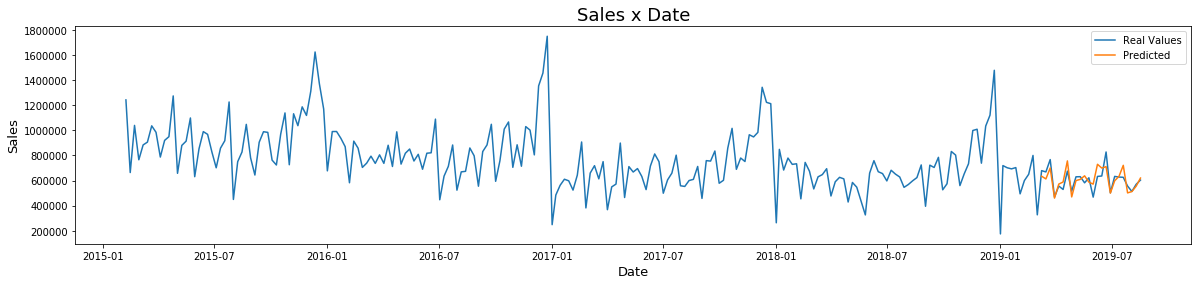

In [34]:
index = pd.to_datetime(df.index)
y = pd.DataFrame(data=scaler.inverse_transform(scaled_df), index=index).iloc[:,0]

# Voltando para escala original
maxi = y.max()
mini = y.min()

rescaled_y_pred = list()

for value in y_pred:
  rescaled_pred = value * (maxi-mini) + mini
  rescaled_y_pred.append(rescaled_pred)

# Plotando o gráfico
plt.figure(figsize=(20,4))
plt.plot(y.index[n_semanas:], y[n_semanas:], label='Real Values')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Sales', fontsize=13)
plt.title('Sales x Date', fontsize=18)
plt.plot(y.index[split_point+n_semanas:], rescaled_y_pred, label='Predicted')
plt.legend()
plt.show()

Aparentemente, o modelo se saiu bem.
Vamos medir o quão bem ele performou através da mesma métrica utilizada nas camadas do modelo, ou seja, vamos usar o Mean Absolute Error.

In [35]:
from sklearn.metrics import mean_absolute_error

round(mean_absolute_error(y[split_point+n_semanas:], rescaled_y_pred), 2)

46791.38

In [36]:
df.Total.mean()

767788.9387136933

Além disso, vamos utilizar o Mean Absolute Percentage Error.

In [0]:
def MAPE(y_test, y_pred):
    return (abs((y_test - y_pred) / y_test) * 100).mean()

In [38]:
MAPE(y[split_point+n_semanas:],rescaled_y_pred)

7.598422954738368

### Salvando o modelo

In [0]:
model_json = model.to_json()
with open("/content/drive/My Drive/UffData/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/UffData/model_weights.h5")